# Random forest Gray2018
A reimplementation of the original random forest proposed in the gray2018 paper

## Creating the input vectors

In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer
import joblib
from Bio import SeqIO

df = pd.read_csv('/home/saul/master_thesis_work/dataset/gray2018/dmsTraining_2017-02-20.csv')

# some of the studies in the training set were excluded from training in the original paper
excluded_studies = ['Brca1_E3', 'Brca1_Y2H', 'E3_ligase']
for study in excluded_studies:
    df = df[df['dms_id'] != study]

# obtain a dictionary with the uniprot sequences for each protein
sequences = {}
for basename in set(df.uniprot_id):
    curr_seq = str(list(SeqIO.parse('/home/saul/master_thesis_work/processing/gray2018/deep_learning/sequences/' + basename + '.fasta', 'fasta'))[0].seq)
    sequences[basename] = curr_seq

len_before = len(df)
        
# remove inconsistencies with the uniprot sequences
index_in_range = pd.Series([row.position - 1 < len(sequences[row.uniprot_id]) for _, row in df.iterrows()], index=df.index)
df = df[index_in_range]
correct_aa1 = pd.Series([row.aa1 == sequences[row.uniprot_id][row.position - 1] for _, row in df.iterrows()], index=df.index)
df = df[correct_aa1]

# check that there are no more inconsistencies
for protein in set(df.uniprot_id.values):
    curr_df = df[df.uniprot_id == protein]
    for position in set(curr_df.position.values):
        aa1_set = set(curr_df[curr_df.position == position].aa1)
        assert len(aa1_set) == 1
        curr_aa1 = aa1_set.pop()
        seq_index = position - 1
        curr_real_res = sequences[protein][seq_index]
        assert curr_aa1 == curr_real_res
                
# print how many entries have been removed (the false values)
len_after = len(df)
print('Removed entries for wrong mapping:', len_before - len_after)

# this df will contain different normalizations of the outputs, and pointers to the protein and dataset of origin
effect_df = pd.DataFrame({'protein': df.protein,
                          'dms_id': df.dms_id,
                          'reported_fitness': df.reported_fitness,
                          'scaled_effect1': df.scaled_effect1})

# scale the maximum positive and negative effects to 1 and -1 without moving the 0
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    x_neg = np.array(curr_df[curr_df.reported_fitness <= 0].reported_fitness).reshape(-1,1)
    x_pos = np.array(curr_df[curr_df.reported_fitness >= 0].reported_fitness).reshape(-1,1)
    scaler = MinMaxScaler()
    x_neg_scaled, x_pos_scaled = -scaler.fit_transform(-x_neg), scaler.fit_transform(x_pos)
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness >= 0) , 'scaled_effect2'] = x_pos_scaled
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness <= 0) , 'scaled_effect2'] = x_neg_scaled

# scale the maximum absolute value to 1, without moving the 0
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = MaxAbsScaler()
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect3'] = x_scaled

# make the distribution uniform (basically uses ranks)
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect4'] = x_scaled
    
# make the distribution normal
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(output_distribution='normal', n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect5'] = x_scaled
    
# make the distribution uniform (basically uses ranks) but separately for positive and negative values
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    x_neg = np.array(curr_df[curr_df.reported_fitness <= 0].reported_fitness).reshape(-1,1)
    x_pos = np.array(curr_df[curr_df.reported_fitness >= 0].reported_fitness).reshape(-1,1)
    scaler = QuantileTransformer(n_quantiles=100)
    x_neg_scaled, x_pos_scaled = -scaler.fit_transform(-x_neg), scaler.fit_transform(x_pos)
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness >= 0) , 'scaled_effect6'] = x_pos_scaled
    effect_df.loc[(effect_df.dms_id == dataset) & (effect_df.reported_fitness <= 0) , 'scaled_effect6'] = x_neg_scaled
    
# make the distribution uniform (basically uses ranks) but crop everything positive to 0
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    # replace positive values with 0
    x[x > 0] = 0
    x_scaled = scaler.fit_transform(-x)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect7'] = x_scaled

# quantile normalization with removal of the wt score
# the idea was taken from Munro2020
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_scaled = scaler.fit_transform(x) - scaler.transform(np.zeros((1,1)))
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect8'] = x_scaled
    
# quantile normalization with removal of the wt score and collapse of all the positive scores to 0
# here 0 is the wt score and 1 the most damaging mutation
for dataset in set(effect_df.dms_id):
    curr_df = effect_df[effect_df.dms_id == dataset]
    scaler = QuantileTransformer(n_quantiles=100)
    x = np.array(curr_df.reported_fitness).reshape(-1,1)
    x_collapsed = - np.minimum(x, 0)
    x_scaled = scaler.fit_transform(x_collapsed)
    effect_df.loc[(effect_df.dms_id == dataset) , 'scaled_effect9'] = x_scaled


# separate numerical and categorical features
is_feature = ['aa1',
              'aa2',
              'WT_Mut', 
              'aa1_polarity',
              'aa2_polarity',
              'aa1_PI', 
              'aa2_PI',
              'deltaPI', 
              'aa1_weight',
              'aa2_weight', 
              'deltaWeight', 
              'aa1vol', 
              'aa2vol', 
              'deltavolume',
              'Grantham', 
              'aa1_psic', 
              'aa2_psic', 
              'delta_psic', 
              'accessibility',
              'dssp_sec_str', 
              'phi_psi_reg', 
              'delta_solvent_accessibility',
              'b_factor', 
              'mut_msa_congruency',
              'mut_mut_msa_congruency',
              'selection_coefficient',
              'evolutionary_coupling_avg', 
              'evolutionary_coupling_prop',
              'evolutionary_coupling_avg_norm']

is_categorical_feature = ['aa1',
                          'aa2',
                          'aa1_polarity',
                          'aa2_polarity',
                          'WT_Mut', 
                          'dssp_sec_str',
                          'phi_psi_reg', 
                         ]

is_numerical_feature = [feature for feature in is_feature if feature not in is_categorical_feature]

x_numerical_list = []
x_numerical_feature_names_list = []
for column in df[is_numerical_feature]:
    x_numerical_list.append(df[column])
    x_numerical_feature_names_list.append(column)
x_numerical = np.array(x_numerical_list).T
x_numerical_feature_names = np.array(x_numerical_feature_names_list).T

# categorical to one-hot encoding
x_categorical = np.array(df[is_categorical_feature])
enc = OneHotEncoder(sparse=False)
to_concat = []
to_concat_feature_names = []
for column, name in zip(x_categorical.T, is_categorical_feature):
    column_one_hot = enc.fit_transform(column.reshape(-1,1))
    to_concat.append(column_one_hot)
    to_concat_feature_names.append(np.array([name + '_onehot_dim_' + str(i) for i in range(column_one_hot.shape[1])]))
x_onehot = np.concatenate(to_concat, axis=1)
x_onehot_feature_names = np.concatenate(to_concat_feature_names)

x = np.concatenate([x_onehot, x_numerical], axis=1)
x_feature_names = np.concatenate([x_onehot_feature_names, x_numerical_feature_names])

x.shape, x_feature_names.shape, len(effect_df)

FileNotFoundError: [Errno 2] No such file or directory: '/home/saul/master_thesis/work/dataset/gray2018/dmsTraining_2017-02-20.csv'

## Cross validation

In [10]:
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
import joblib


def lopo_plots_and_correlation(x, df, target):
    y = np.array(df[target])
    regr = RandomForestRegressor(n_jobs=-1, bootstrap=True, oob_score=False, n_estimators=100, verbose=0)
    lopo = LeaveOneGroupOut()
    max_spearman, min_spearman = -100, 100 # reversed since I want them to be updated
    max_pearson, min_pearson = -100, 100
    results = []
    for train, val in lopo.split(x, groups=df.protein):
        curr_protein_tested = list(set(df.protein.iloc[val]))
        assert len(curr_protein_tested) == 1
        print('Protein:', curr_protein_tested[0])
        imp = SimpleImputer()
        imp.fit(x[train])
        x_imputed = imp.transform(x)
        regr.fit(x_imputed[train], y[train])
        y_pred = regr.predict(x_imputed[val])
        for dataset in list(set(df.dms_id.iloc[val])):
            print('Dataset:', dataset)
            y_pred_to_show, y_test_to_show = y_pred[df.dms_id.iloc[val] == dataset].flatten(), y[val][df.dms_id.iloc[val] == dataset].flatten()
            curr_spearman = stats.spearmanr(y_pred_to_show, y_test_to_show)[0]
            max_spearman, min_spearman = max(max_spearman, curr_spearman), min(min_spearman, curr_spearman)
            results.append([dataset, curr_spearman, [y_pred_to_show, y_test_to_show]])
            print('spearman:', curr_spearman)           
            plt.close()
            sns.scatterplot(x=y_pred_to_show, y=y_test_to_show, s=10)
            plt.show()           
    print('Overall min spearman:', min_spearman, '\nOverall max spearman', max_spearman)
    result = pd.DataFrame(results, columns=['dataset', 'spearman', 'full_results']) 
    return results

In [11]:
bool_numerical = np.array([feature in is_numerical_feature for feature in x_feature_names])
x_numerical, x_categorical = x[:,bool_numerical], x[:, np.logical_not(bool_numerical)]

Protein: Kka2
Dataset: kka2_1:2
spearman: 0.6575343617512677


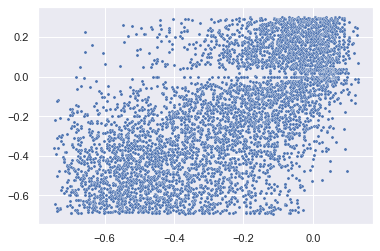

Protein: PSD95pdz3
Dataset: PSD95pdz3
spearman: 0.38367152891730116


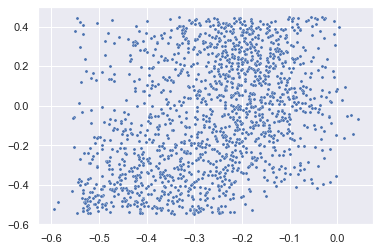

Protein: Pab1
Dataset: Pab1
spearman: 0.5822686073262664


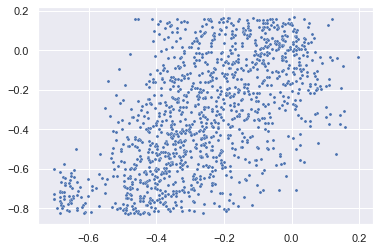

Protein: TEM-1
Dataset: beta-lactamase
spearman: 0.709519735899514


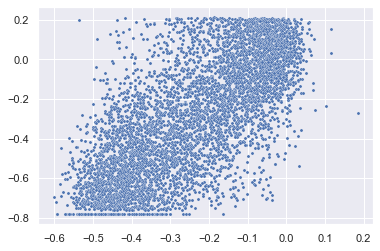

Protein: UBI4
Dataset: Ubiquitin
spearman: 0.526090962717818


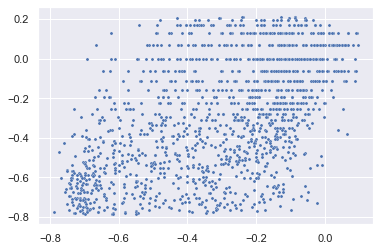

Dataset: E1_Ubiquitin
spearman: 0.5488094509549003


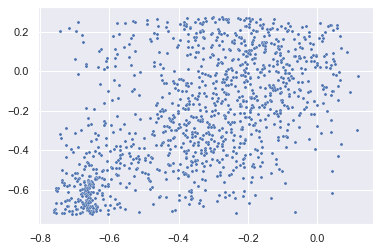

Protein: Yap65
Dataset: WW_domain
spearman: 0.30186881269052956


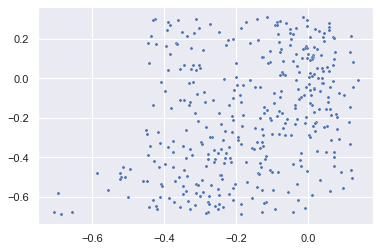

Protein: gb1
Dataset: gb1
spearman: 0.43552510616880635


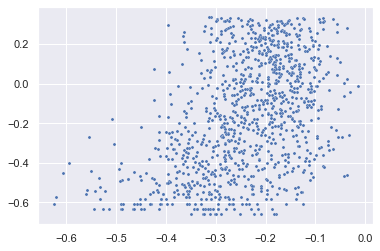

Protein: hsp90
Dataset: hsp90
spearman: 0.3520753210379062


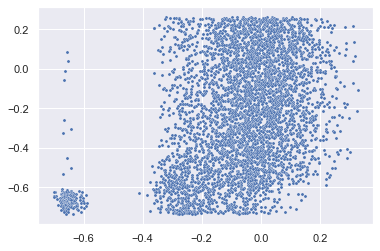

Overall min spearman: 0.30186881269052956 
Overall max spearman 0.709519735899514


In [13]:
results = lopo_plots_and_correlation(x, effect_df, 'scaled_effect8')